Imports

# Comparison of Gradient Descent, Block Coordinate Gradient Descent and Coordinate Minimization methods

## Introduction

In the following cells we will compare different solvers (Gradient Descent, BCGD and Coordinate Minimization) using a Radial Basis Function Kernel (RBF).\
The RBF kernel computes similarity as $K(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2)$.\



In [18]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import rbf_kernel
from solvers_digits import GradientDescentSolver, BCGDSolver, CoordinateMinimizationSolver
import time
import random

import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 Load & Preprocess Digits Data

In [19]:
def load_digits_data_pca(n_components=10):
   #Load dataset from sklearn
   #Dataset contains 8x8 grayscale images of handwritten digits (0-9)
   data = load_digits()

   # Extract input features (64-dimensional pixel values)
   X = data.data   # shape: (n_samples, 64)

   # Convert the multi-class labels (10-class problem) to a binary classification problem
   # We set y = 1 if the digit is a "0", and y = 0 otherwise
   y = (data.target == 0).astype(int)  # Binary classification: "0" vs "not 0"

   # Standardize the features: zero mean and unit variance
   # Curicial for PCA and Kernel methods to behave well
   X_scaled = StandardScaler().fit_transform(X)

   # Apply PCA to reduce the feature space to 'n_components' dimensions
   # keeps the most important variance directions
   X_reduced = PCA(n_components=n_components).fit_transform(X_scaled)

   # returns reduced dataset and binary labels
   return X_reduced, y


SSL Split + Init Solvers | Train & Clip Predictions

Labeled class distribution: [161  18]
Step size (1/L): 0.003272
Step size (2/(L+σ)): 0.006544


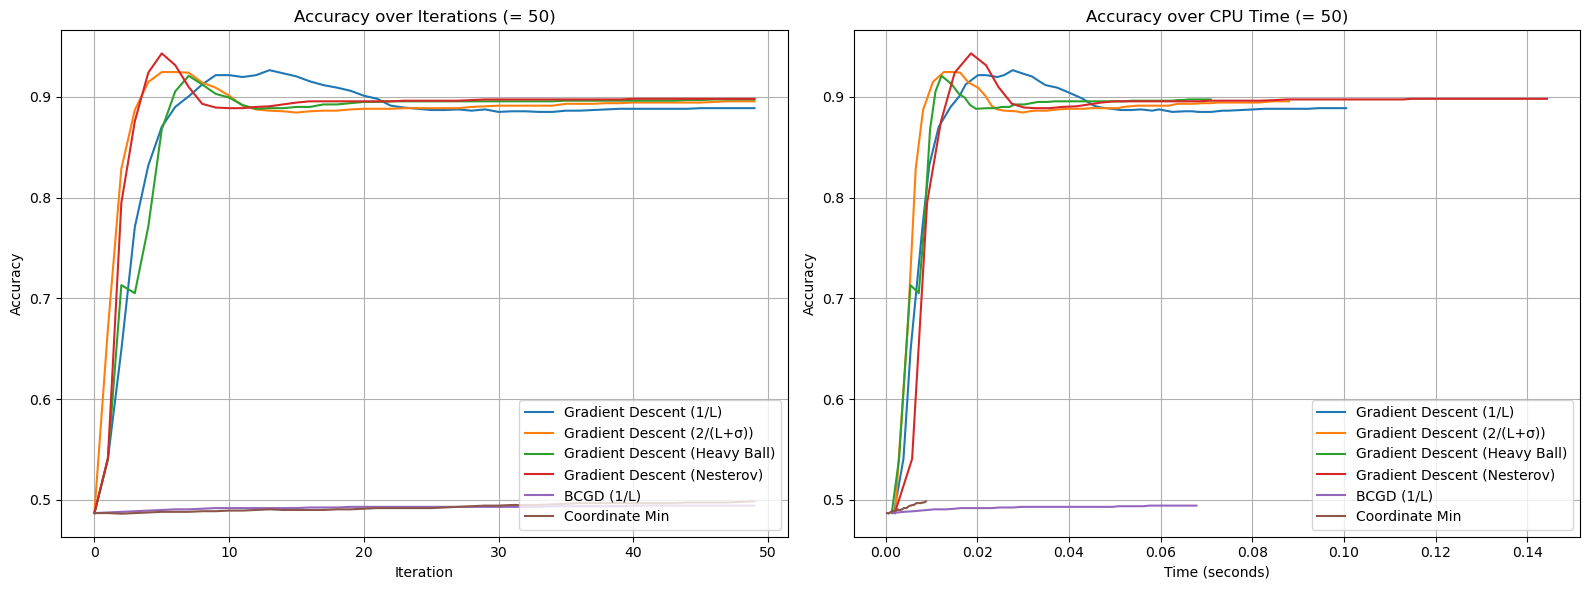

<Figure size 640x480 with 0 Axes>

In [ ]:
# Load the digits dataset, reduced to 10 PCA components
# Also convert labels into a binary classification: 1 if digit == 0, else 0
X, y = load_digits_data_pca(n_components=10)

# Split the dataset into a small labeled subset and a large unlabeled subset
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(
    X, y, train_size=0.1, stratify=y, random_state=42)

# Print how many samples of class 0 and non-0 are in the labeled set
# Checking the imbalance
print("Labeled class distribution:", np.bincount(Y_labeled))

# Set random seeds for reproducibility of all randomized steps
np.random.seed(42)
random.seed(42)

# Initialize soft labels for the unlabeled set with values in [0, 1]
# These values will be optimized during training
y_init = np.random.rand(X_unlabeled.shape[0])

# Set RBF kernel parameter gamma
# common heurestic is to set gamma = 1 / num_features
gamma = 1 / X.shape[1]
max_iters = 50

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")


# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "Gradient Descent (Heavy Ball)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.8),
    "Gradient Descent (Nesterov)": GradientDescentSolver(X_labeled,Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.9, nesterov=True),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    #"BCGD (cache)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=True, lr=0.0005), 
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}



# Precompute the similarity matrices (using the RBF kernel)
for solver in solvers.values():
    solver.W_lu = rbf_kernel(solver.X_labeled, solver.X_unlabeled, gamma=gamma)
    solver.W_uu = rbf_kernel(solver.X_unlabeled, solver.X_unlabeled, gamma=gamma)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for name, solver in solvers.items():
    acc_list = []  #stores accuracy at each iteration
    time_list = []    # stores elapsed CPU time at each iteration
    start_time = time.time()  # start timing the solver

    for _ in range(max_iters):
        # predict binary labels and assign 1, if soft-label > 0.5
        y_pred = (solver.y_unlabeled > 0.5)

        # compute accuracy on the unlabeled ground-truth labels
        acc = accuracy_score(Y_unlabeled, y_pred)
        acc_list.append(acc)

        # take one optimization step with the selected solver
        solver.step()

        # clip label values so they stay in the valid range [0, 1]
        np.clip(solver.y_unlabeled, 0, 1, out=solver.y_unlabeled)

        # Record elapsed CPU time
        time_list.append(time.time() - start_time)


    ax1.plot(acc_list, label=name)
    ax2.plot(time_list, acc_list, label=name)

ax1.set_title("Accuracy over Iterations (= 50)")
ax2.set_title("Accuracy over CPU Time (= 50)")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Time (seconds)")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
ax1.grid(); ax2.grid(); ax1.legend(loc = 'lower right'); ax2.legend(loc = 'lower right')
plt.tight_layout(); plt.show()

# Save before showing
plt.savefig("acc_gd_it100.png", dpi=300, bbox_inches="tight")

# Then show
plt.show()

Implementation of Loss Function and Metrics

Labeled class distribution: [161  18]
Step size (1/L): 0.003255
Step size (2/(L+σ)): 0.006510


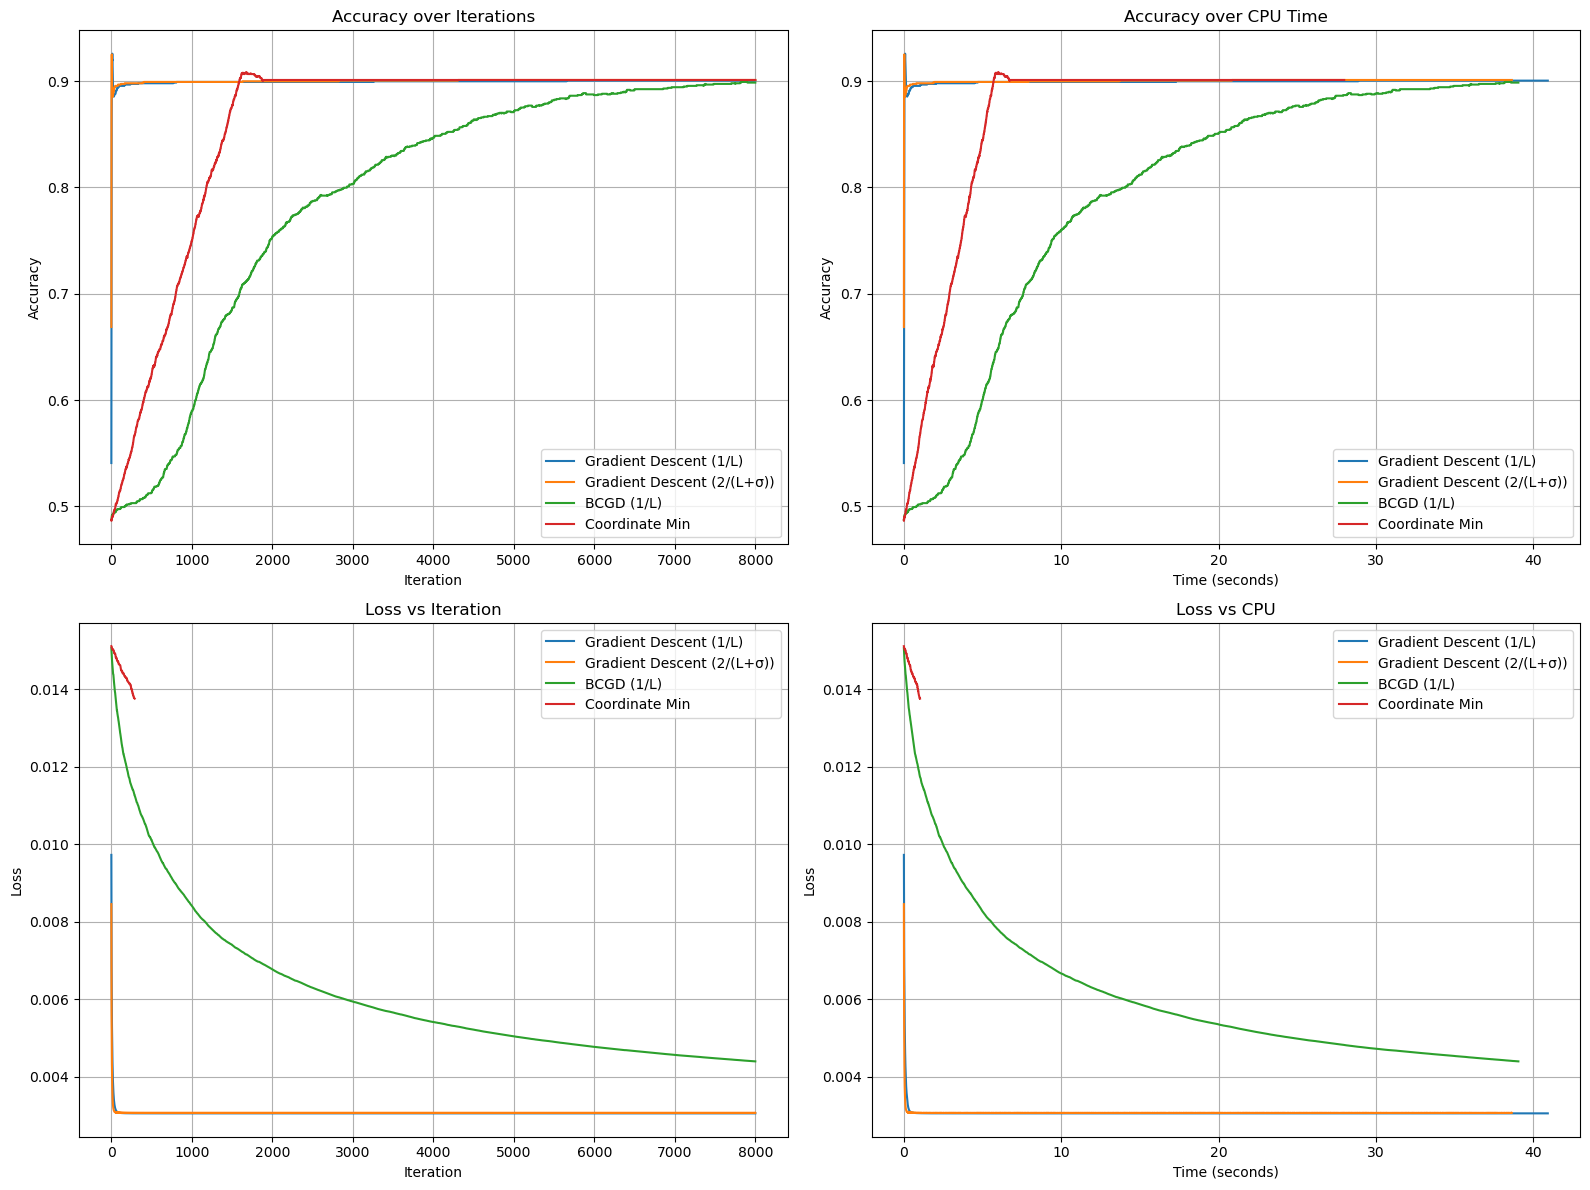

                       Solver  Accuracy  Precision  Recall        F1
0      Gradient Descent (1/L)  0.900494   0.000000  0.0000  0.000000
1  Gradient Descent (2/(L+σ))  0.901112   0.000000  0.0000  0.000000
2                  BCGD (1/L)  0.898640   0.483333  0.3625  0.414286
3              Coordinate Min  0.901112   0.000000  0.0000  0.000000


In [ ]:
# Load the digits dataset, reduced to 10 PCA components
# Also convert labels into a binary classification: 1 if digit == 0, else 0
X, y = load_digits_data_pca(n_components=10)

# Split the dataset into a small labeled subset and a large unlabeled subset
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(
    X, y, train_size=0.1, stratify=y, random_state=42)

# Print how many samples of class 0 and non-0 are in the labeled set
# Checking the imbalance
print("Labeled class distribution:", np.bincount(Y_labeled))

# Set random seeds for reproducibility of all randomized steps
np.random.seed(42)
random.seed(42)

# Initialize soft labels for the unlabeled set with values in [0, 1]
# These values will be optimized during training
y_init = np.random.rand(X_unlabeled.shape[0])

# Set RBF kernel parameter gamma
# common heurestic is to set gamma = 1 / num_features
gamma = 1 / X.shape[1]
max_iters = 8000

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")

# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}


# Precompute the similarity matrices (using the RBF kernel)
for solver in solvers.values():
    solver.W_lu = rbf_kernel(solver.X_labeled, solver.X_unlabeled, gamma=gamma)
    solver.W_uu = rbf_kernel(solver.X_unlabeled, solver.X_unlabeled, gamma=gamma)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


for name, solver in solvers.items():
    acc_list = []  #stores accuracy at each iteration
    time_list = []    # stores elapsed CPU time at each iteration
    loss_list = []
    start_time = time.time()  # start timing the solver

    for _ in range(max_iters):

        # take one optimization step with the selected solver
        solver.step()
        
        # predict binary labels and assign 1, if soft-label > 0.5
        y_pred = (solver.y_unlabeled > 0.5)

        # compute accuracy on the unlabeled ground-truth labels
        acc = accuracy_score(Y_unlabeled, y_pred)
        acc_list.append(acc)

        

        # clip label values so they stay in the valid range [0, 1]
        np.clip(solver.y_unlabeled, 0, 1, out=solver.y_unlabeled)

        # Record elapsed CPU time
        elapsed = time.time() - start_time
        time_list.append(elapsed)

        # compute loss from the different solvers
        loss = solver.compute_loss()
        loss_list.append(loss)

    # Plot accuracy
    ax1.plot(acc_list, label=name)
    ax2.plot(time_list, acc_list, label=name)

    # Plot loss
    ax3.plot(loss_list, label=name)
    ax4.plot(time_list, loss_list, label=name)

ax1.set_title("Accuracy over Iterations")
ax2.set_title("Accuracy over CPU Time")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Time (seconds)")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
ax1.grid(); ax2.grid(); ax1.legend(); ax2.legend()

ax3.set_title('Loss vs Iteration')
ax4.set_title('Loss vs CPU')
ax3.set_xlabel('Iteration')
ax4.set_xlabel('Time (seconds)')
ax3.set_ylabel('Loss')
ax4.set_ylabel('Loss')
ax3.legend(); ax4.legend(); ax3.grid(); ax4.grid()
plt.tight_layout(); plt.show()

# Print final metrics
final_metrics = []
for name, solver in solvers.items():
    y_pred = (solver.y_unlabeled > 0.5).astype(int)
    final_metrics.append({
        'Solver': name,
        'Accuracy': accuracy_score(Y_unlabeled, y_pred),
        'Precision': precision_score(Y_unlabeled, y_pred, zero_division=0),
        'Recall': recall_score(Y_unlabeled, y_pred),
        'F1': f1_score(Y_unlabeled, y_pred)
    })

print(pd.DataFrame(final_metrics))




Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(f"\n{name} Classification Report")
print(classification_report(Y_unlabeled, y_pred, digits=4))

print(f"{name} → Predicted positives: {np.sum(y_pred)}")




Coordinate Min Classification Report
              precision    recall  f1-score   support

           0     0.9011    1.0000    0.9480      1458
           1     0.0000    0.0000    0.0000       160

    accuracy                         0.9011      1618
   macro avg     0.4506    0.5000    0.4740      1618
weighted avg     0.8120    0.9011    0.8542      1618

Coordinate Min → Predicted positives: 0


In [ ]:
final_preds = (solvers["Coordinate Min"].y_unlabeled > 0.5)

print(f"Coordinate Minimization results:")
print(f"Iterations: {400}")
print(f"Predicted positives: {sum(final_preds)}")

Coordinate Minimization results:
Iterations: 400
Predicted positives: 0


# Redundant Plotting: Accuracy over varying Training Size

## Results:
Training Sizes [0.1, 0.08, 0.05, 0.03, 0.01]
see graphs:

Training Size = 0.1

Labeled class distribution: [161  18]
Step size (1/L): 0.003255
Step size (2/(L+σ)): 0.006510


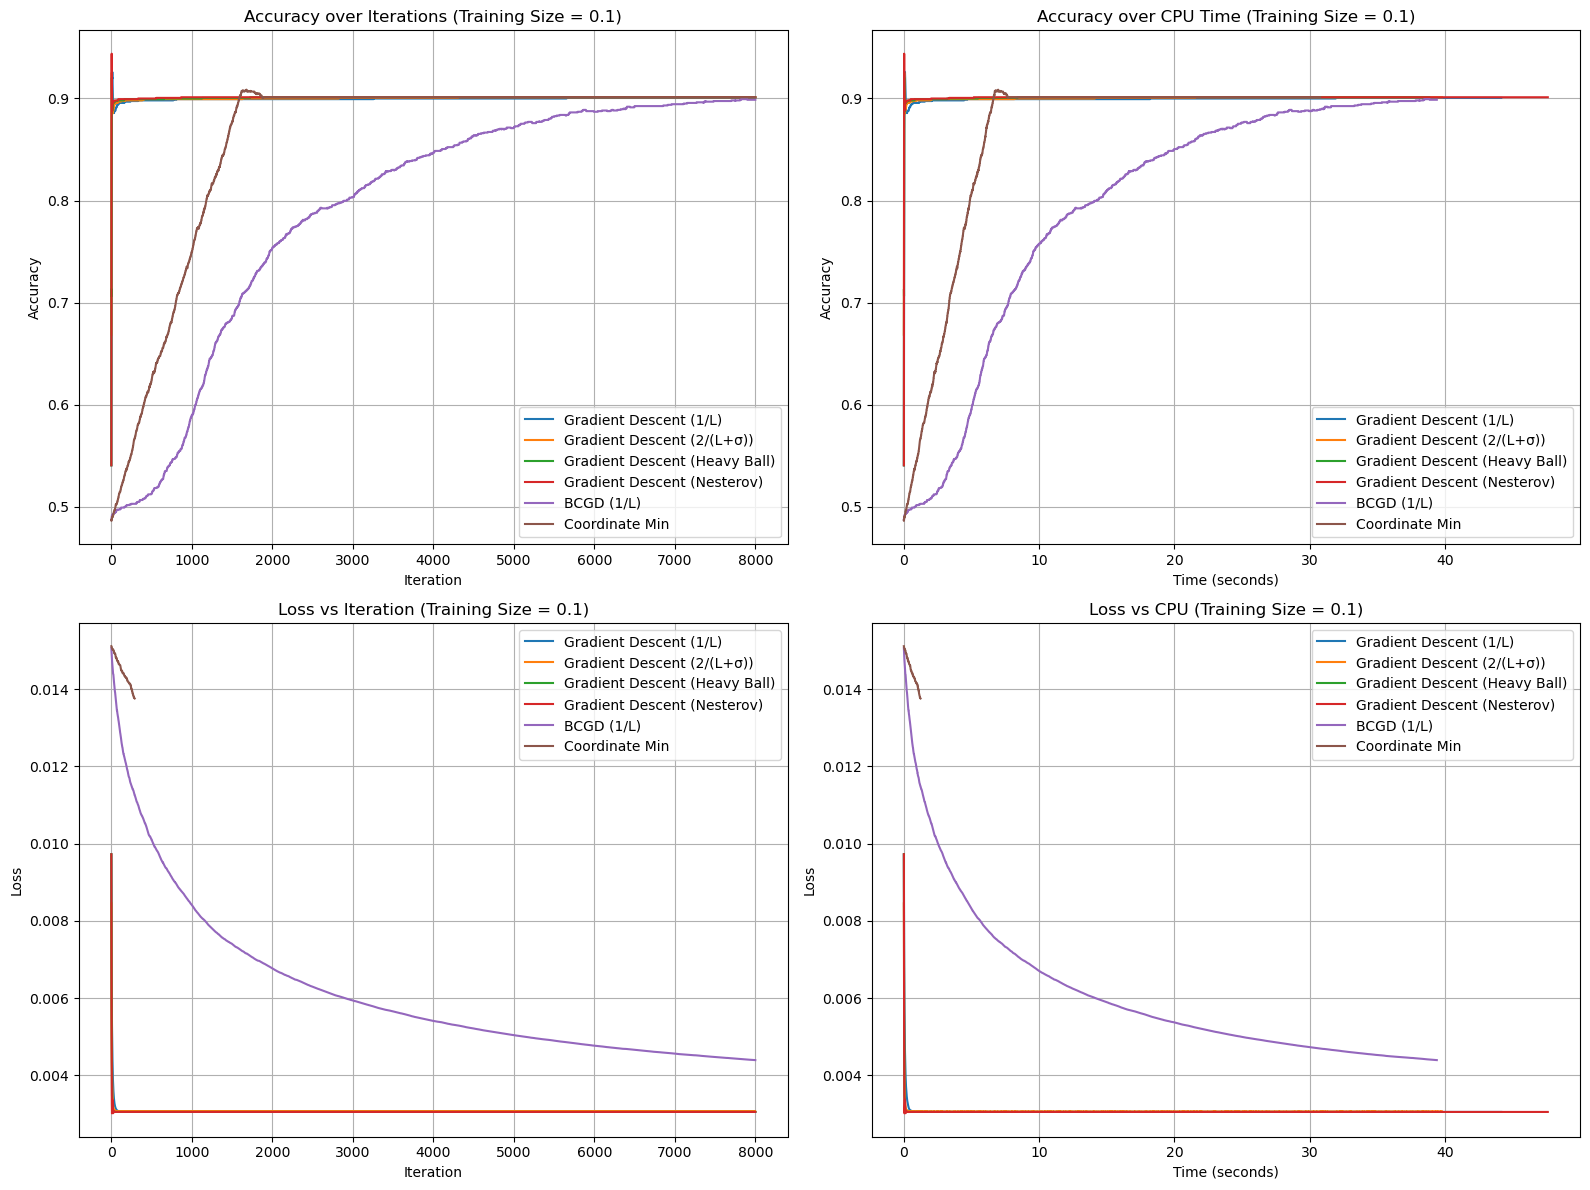

                          Solver  Accuracy  Precision  Recall        F1
0         Gradient Descent (1/L)  0.900494   0.000000  0.0000  0.000000
1     Gradient Descent (2/(L+σ))  0.901112   0.000000  0.0000  0.000000
2  Gradient Descent (Heavy Ball)  0.901112   0.000000  0.0000  0.000000
3    Gradient Descent (Nesterov)  0.901112   0.000000  0.0000  0.000000
4                     BCGD (1/L)  0.898640   0.483333  0.3625  0.414286
5                 Coordinate Min  0.901112   0.000000  0.0000  0.000000


In [21]:
# Load the digits dataset, reduced to 10 PCA components
# Also convert labels into a binary classification: 1 if digit == 0, else 0
X, y = load_digits_data_pca(n_components=10)

# Split the dataset into a small labeled subset and a large unlabeled subset
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(
    X, y, train_size=0.1, stratify=y, random_state=42)

# Print how many samples of class 0 and non-0 are in the labeled set
# Checking the imbalance
print("Labeled class distribution:", np.bincount(Y_labeled))

# Set random seeds for reproducibility of all randomized steps
np.random.seed(42)
random.seed(42)

# Initialize soft labels for the unlabeled set with values in [0, 1]
# These values will be optimized during training
y_init = np.random.rand(X_unlabeled.shape[0])

# Set RBF kernel parameter gamma
# common heurestic is to set gamma = 1 / num_features
gamma = 1 / X.shape[1]
max_iters = 8000

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")

# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "Gradient Descent (Heavy Ball)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.8),
    "Gradient Descent (Nesterov)": GradientDescentSolver(X_labeled,Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.9, nesterov=True),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    #"BCGD (cache)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=True, lr=0.0005), 
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}

# Precompute the similarity matrices (using the RBF kernel)
for solver in solvers.values():
    solver.W_lu = rbf_kernel(solver.X_labeled, solver.X_unlabeled, gamma=gamma)
    solver.W_uu = rbf_kernel(solver.X_unlabeled, solver.X_unlabeled, gamma=gamma)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


for name, solver in solvers.items():
    acc_list = []  #stores accuracy at each iteration
    time_list = []    # stores elapsed CPU time at each iteration
    loss_list = []
    start_time = time.time()  # start timing the solver

    for _ in range(max_iters):

        # take one optimization step with the selected solver
        solver.step()
        
        # predict binary labels and assign 1, if soft-label > 0.5
        y_pred = (solver.y_unlabeled > 0.5)

        # compute accuracy on the unlabeled ground-truth labels
        acc = accuracy_score(Y_unlabeled, y_pred)
        acc_list.append(acc)

        

        # clip label values so they stay in the valid range [0, 1]
        np.clip(solver.y_unlabeled, 0, 1, out=solver.y_unlabeled)

        # Record elapsed CPU time
        elapsed = time.time() - start_time
        time_list.append(elapsed)

        # compute loss from the different solvers
        loss = solver.compute_loss()
        loss_list.append(loss)

    # Plot accuracy
    ax1.plot(acc_list, label=name)
    ax2.plot(time_list, acc_list, label=name)

    # Plot loss
    ax3.plot(loss_list, label=name)
    ax4.plot(time_list, loss_list, label=name)

ax1.set_title("Accuracy over Iterations (Training Size = 0.1)")
ax2.set_title("Accuracy over CPU Time (Training Size = 0.1)")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Time (seconds)")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
ax1.grid(); ax2.grid(); ax1.legend(); ax2.legend()

ax3.set_title('Loss vs Iteration (Training Size = 0.1)')
ax4.set_title('Loss vs CPU (Training Size = 0.1)')
ax3.set_xlabel('Iteration')
ax4.set_xlabel('Time (seconds)')
ax3.set_ylabel('Loss')
ax4.set_ylabel('Loss')
ax3.legend(); ax4.legend(); ax3.grid(); ax4.grid()
plt.tight_layout(); plt.show()

# Print final metrics
final_metrics = []
for name, solver in solvers.items():
    y_pred = (solver.y_unlabeled > 0.5).astype(int)
    final_metrics.append({
        'Solver': name,
        'Accuracy': accuracy_score(Y_unlabeled, y_pred),
        'Precision': precision_score(Y_unlabeled, y_pred, zero_division=0),
        'Recall': recall_score(Y_unlabeled, y_pred),
        'F1': f1_score(Y_unlabeled, y_pred)
    })

print(pd.DataFrame(final_metrics))




Training Size = 0.08

Labeled class distribution: [129  14]
Step size (1/L): 0.003150
Step size (2/(L+σ)): 0.006300


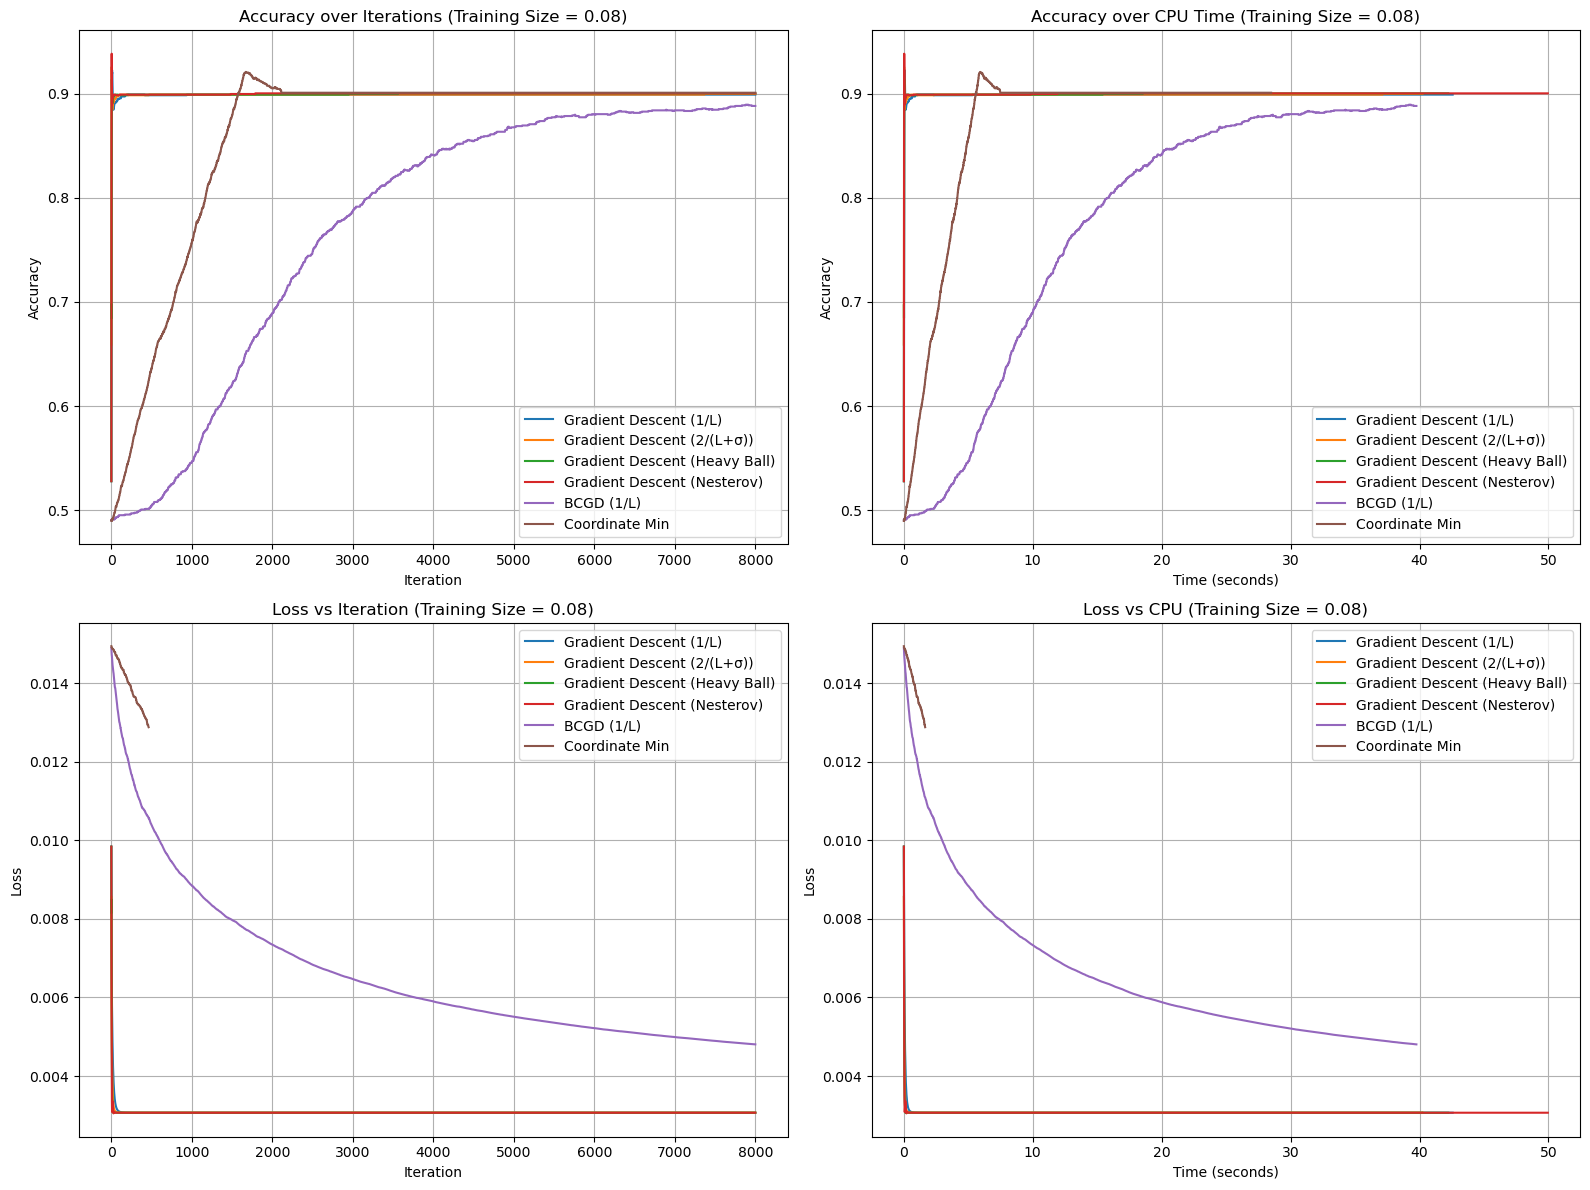

                          Solver  Accuracy  Precision    Recall       F1
0         Gradient Descent (1/L)  0.899033   0.000000  0.000000  0.00000
1     Gradient Descent (2/(L+σ))  0.899637   0.000000  0.000000  0.00000
2  Gradient Descent (Heavy Ball)  0.900242   0.000000  0.000000  0.00000
3    Gradient Descent (Nesterov)  0.900242   0.000000  0.000000  0.00000
4                     BCGD (1/L)  0.888150   0.384615  0.213415  0.27451
5                 Coordinate Min  0.900846   0.000000  0.000000  0.00000


In [22]:
# Load the digits dataset, reduced to 10 PCA components
# Also convert labels into a binary classification: 1 if digit == 0, else 0
X, y = load_digits_data_pca(n_components=10)

# Split the dataset into a small labeled subset and a large unlabeled subset
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(
    X, y, train_size=0.08, stratify=y, random_state=42)

# Print how many samples of class 0 and non-0 are in the labeled set
# Checking the imbalance
print("Labeled class distribution:", np.bincount(Y_labeled))

# Set random seeds for reproducibility of all randomized steps
np.random.seed(42)
random.seed(42)

# Initialize soft labels for the unlabeled set with values in [0, 1]
# These values will be optimized during training
y_init = np.random.rand(X_unlabeled.shape[0])

# Set RBF kernel parameter gamma
# common heurestic is to set gamma = 1 / num_features
gamma = 1 / X.shape[1]
max_iters = 8000

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")

# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "Gradient Descent (Heavy Ball)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.8),
    "Gradient Descent (Nesterov)": GradientDescentSolver(X_labeled,Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.9, nesterov=True),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    #"BCGD (cache)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=True, lr=0.0005), 
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}

# Precompute the similarity matrices (using the RBF kernel)
for solver in solvers.values():
    solver.W_lu = rbf_kernel(solver.X_labeled, solver.X_unlabeled, gamma=gamma)
    solver.W_uu = rbf_kernel(solver.X_unlabeled, solver.X_unlabeled, gamma=gamma)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


for name, solver in solvers.items():
    acc_list = []  #stores accuracy at each iteration
    time_list = []    # stores elapsed CPU time at each iteration
    loss_list = []
    start_time = time.time()  # start timing the solver

    for _ in range(max_iters):

        # take one optimization step with the selected solver
        solver.step()
        
        # predict binary labels and assign 1, if soft-label > 0.5
        y_pred = (solver.y_unlabeled > 0.5)

        # compute accuracy on the unlabeled ground-truth labels
        acc = accuracy_score(Y_unlabeled, y_pred)
        acc_list.append(acc)

        

        # clip label values so they stay in the valid range [0, 1]
        np.clip(solver.y_unlabeled, 0, 1, out=solver.y_unlabeled)

        # Record elapsed CPU time
        elapsed = time.time() - start_time
        time_list.append(elapsed)

        # compute loss from the different solvers
        loss = solver.compute_loss()
        loss_list.append(loss)

    # Plot accuracy
    ax1.plot(acc_list, label=name)
    ax2.plot(time_list, acc_list, label=name)

    # Plot loss
    ax3.plot(loss_list, label=name)
    ax4.plot(time_list, loss_list, label=name)

ax1.set_title("Accuracy over Iterations (Training Size = 0.08)")
ax2.set_title("Accuracy over CPU Time (Training Size = 0.08)")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Time (seconds)")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
ax1.grid(); ax2.grid(); ax1.legend(); ax2.legend()

ax3.set_title('Loss vs Iteration (Training Size = 0.08)')
ax4.set_title('Loss vs CPU (Training Size = 0.08)')
ax3.set_xlabel('Iteration')
ax4.set_xlabel('Time (seconds)')
ax3.set_ylabel('Loss')
ax4.set_ylabel('Loss')
ax3.legend(); ax4.legend(); ax3.grid(); ax4.grid()
plt.tight_layout(); plt.show()

# Print final metrics
final_metrics = []
for name, solver in solvers.items():
    y_pred = (solver.y_unlabeled > 0.5).astype(int)
    final_metrics.append({
        'Solver': name,
        'Accuracy': accuracy_score(Y_unlabeled, y_pred),
        'Precision': precision_score(Y_unlabeled, y_pred, zero_division=0),
        'Recall': recall_score(Y_unlabeled, y_pred),
        'F1': f1_score(Y_unlabeled, y_pred)
    })

print(pd.DataFrame(final_metrics))




Training Size = 0.05

Labeled class distribution: [80  9]
Step size (1/L): 0.003016
Step size (2/(L+σ)): 0.006033


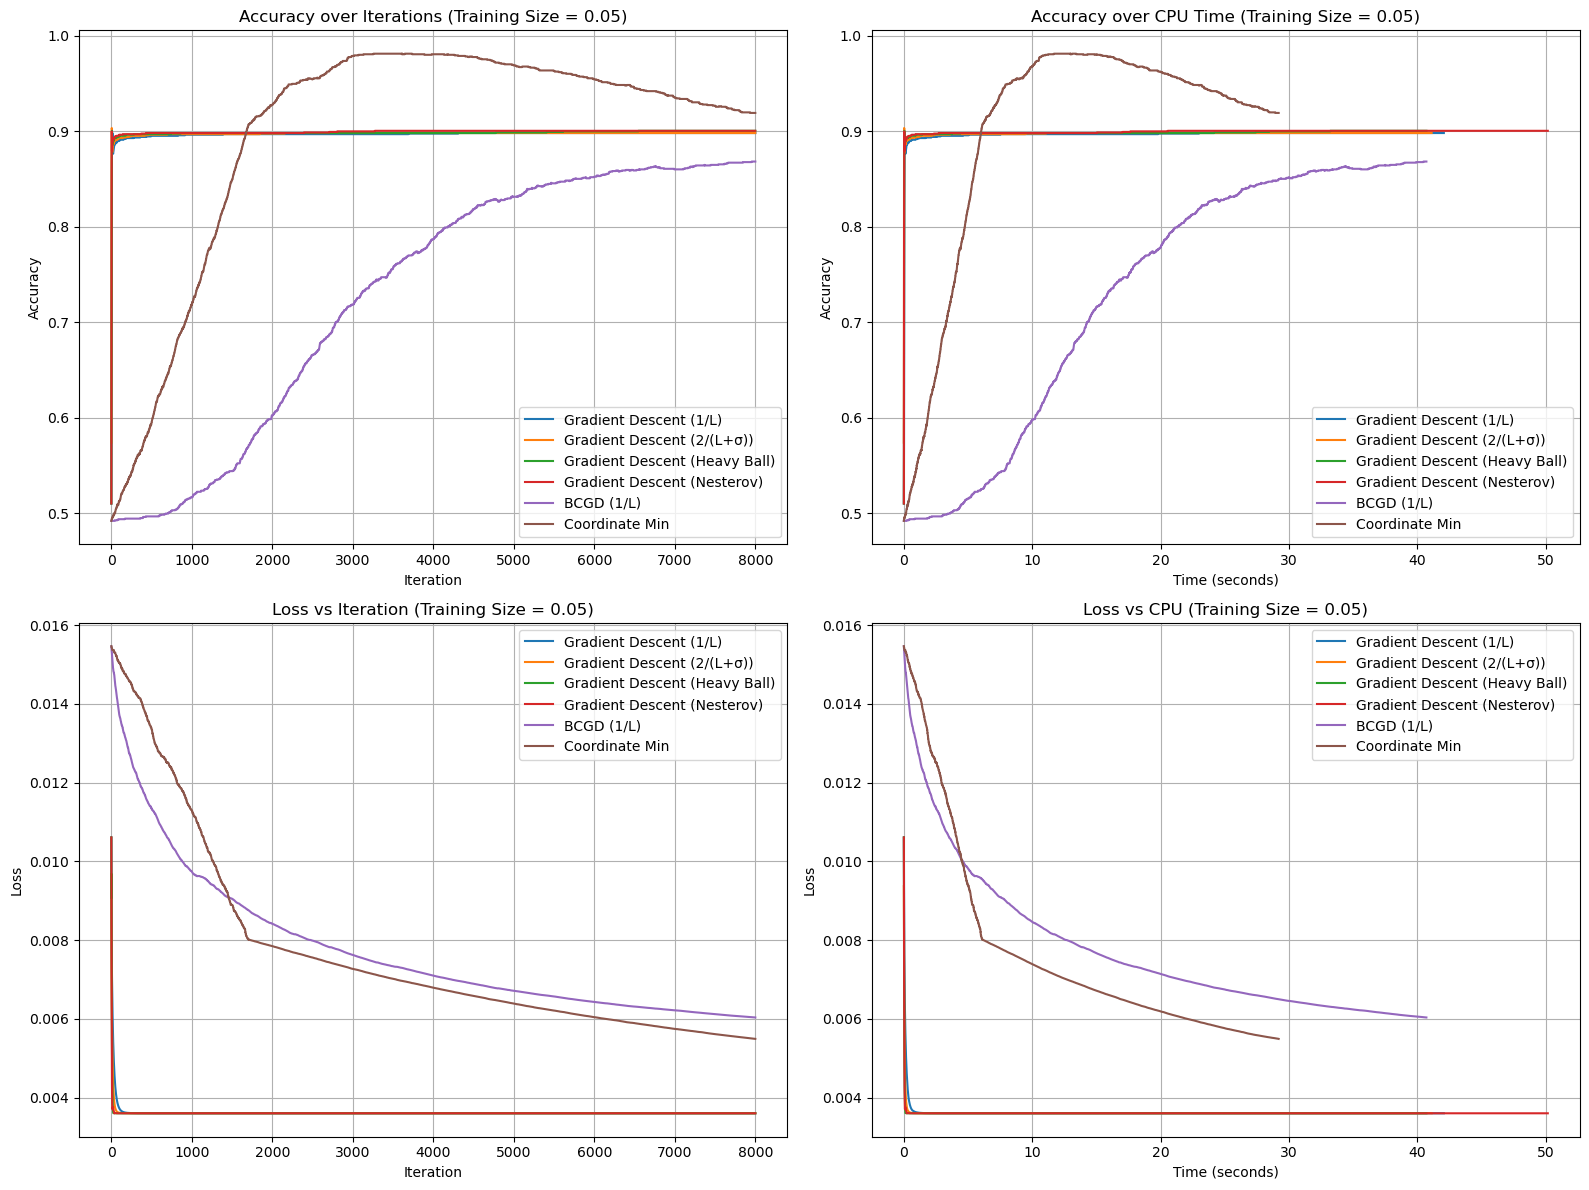

                          Solver  Accuracy  Precision    Recall        F1
0         Gradient Descent (1/L)  0.898126   0.000000  0.000000  0.000000
1     Gradient Descent (2/(L+σ))  0.898126   0.000000  0.000000  0.000000
2  Gradient Descent (Heavy Ball)  0.900468   0.000000  0.000000  0.000000
3    Gradient Descent (Nesterov)  0.900468   0.000000  0.000000  0.000000
4                     BCGD (1/L)  0.868267   0.240741  0.153846  0.187726
5                 Coordinate Min  0.919204   0.897436  0.207101  0.336538


In [23]:
# Load the digits dataset, reduced to 10 PCA components
# Also convert labels into a binary classification: 1 if digit == 0, else 0
X, y = load_digits_data_pca(n_components=10)

# Split the dataset into a small labeled subset and a large unlabeled subset
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(
    X, y, train_size=0.05, stratify=y, random_state=42)

# Print how many samples of class 0 and non-0 are in the labeled set
# Checking the imbalance
print("Labeled class distribution:", np.bincount(Y_labeled))

# Set random seeds for reproducibility of all randomized steps
np.random.seed(42)
random.seed(42)

# Initialize soft labels for the unlabeled set with values in [0, 1]
# These values will be optimized during training
y_init = np.random.rand(X_unlabeled.shape[0])

# Set RBF kernel parameter gamma
# common heurestic is to set gamma = 1 / num_features
gamma = 1 / X.shape[1]
max_iters = 8000

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")

# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "Gradient Descent (Heavy Ball)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.8),
    "Gradient Descent (Nesterov)": GradientDescentSolver(X_labeled,Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.9, nesterov=True),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    #"BCGD (cache)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=True, lr=0.0005), 
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}

# Precompute the similarity matrices (using the RBF kernel)
for solver in solvers.values():
    solver.W_lu = rbf_kernel(solver.X_labeled, solver.X_unlabeled, gamma=gamma)
    solver.W_uu = rbf_kernel(solver.X_unlabeled, solver.X_unlabeled, gamma=gamma)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


for name, solver in solvers.items():
    acc_list = []  #stores accuracy at each iteration
    time_list = []    # stores elapsed CPU time at each iteration
    loss_list = []
    start_time = time.time()  # start timing the solver

    for _ in range(max_iters):

        # take one optimization step with the selected solver
        solver.step()
        
        # predict binary labels and assign 1, if soft-label > 0.5
        y_pred = (solver.y_unlabeled > 0.5)

        # compute accuracy on the unlabeled ground-truth labels
        acc = accuracy_score(Y_unlabeled, y_pred)
        acc_list.append(acc)

        

        # clip label values so they stay in the valid range [0, 1]
        np.clip(solver.y_unlabeled, 0, 1, out=solver.y_unlabeled)

        # Record elapsed CPU time
        elapsed = time.time() - start_time
        time_list.append(elapsed)

        # compute loss from the different solvers
        loss = solver.compute_loss()
        loss_list.append(loss)

    # Plot accuracy
    ax1.plot(acc_list, label=name)
    ax2.plot(time_list, acc_list, label=name)

    # Plot loss
    ax3.plot(loss_list, label=name)
    ax4.plot(time_list, loss_list, label=name)

ax1.set_title("Accuracy over Iterations (Training Size = 0.05)")
ax2.set_title("Accuracy over CPU Time (Training Size = 0.05)")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Time (seconds)")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
ax1.grid(); ax2.grid(); ax1.legend(); ax2.legend()

ax3.set_title('Loss vs Iteration (Training Size = 0.05)')
ax4.set_title('Loss vs CPU (Training Size = 0.05)')
ax3.set_xlabel('Iteration')
ax4.set_xlabel('Time (seconds)')
ax3.set_ylabel('Loss')
ax4.set_ylabel('Loss')
ax3.legend(); ax4.legend(); ax3.grid(); ax4.grid()
plt.tight_layout(); plt.show()

# Print final metrics
final_metrics = []
for name, solver in solvers.items():
    y_pred = (solver.y_unlabeled > 0.5).astype(int)
    final_metrics.append({
        'Solver': name,
        'Accuracy': accuracy_score(Y_unlabeled, y_pred),
        'Precision': precision_score(Y_unlabeled, y_pred, zero_division=0),
        'Recall': recall_score(Y_unlabeled, y_pred),
        'F1': f1_score(Y_unlabeled, y_pred)
    })

print(pd.DataFrame(final_metrics))




Training Size = 0.03

Labeled class distribution: [48  5]
Step size (1/L): 0.002983
Step size (2/(L+σ)): 0.005966


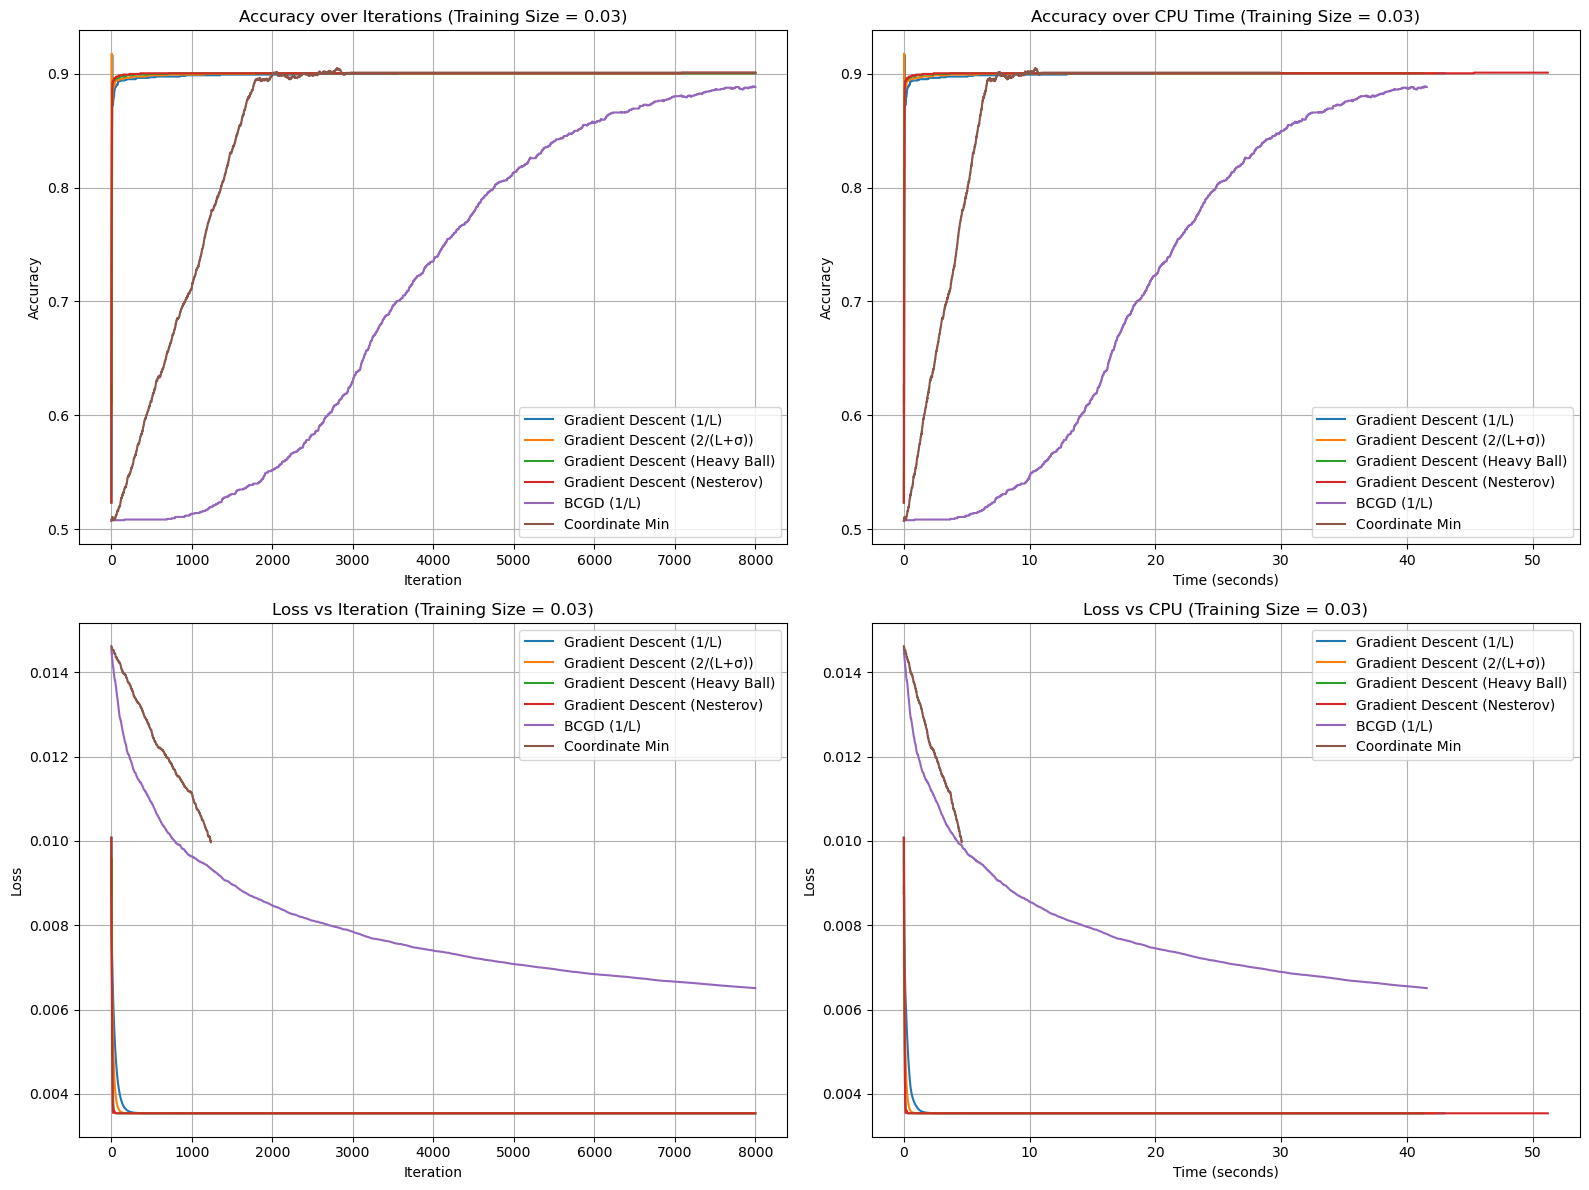

                          Solver  Accuracy  Precision    Recall        F1
0         Gradient Descent (1/L)  0.900229   0.000000  0.000000  0.000000
1     Gradient Descent (2/(L+σ))  0.900229   0.000000  0.000000  0.000000
2  Gradient Descent (Heavy Ball)  0.900229   0.000000  0.000000  0.000000
3    Gradient Descent (Nesterov)  0.900803   0.000000  0.000000  0.000000
4                     BCGD (1/L)  0.888188   0.433735  0.416185  0.424779
5                 Coordinate Min  0.900803   0.000000  0.000000  0.000000


In [24]:
# Load the digits dataset, reduced to 10 PCA components
# Also convert labels into a binary classification: 1 if digit == 0, else 0
X, y = load_digits_data_pca(n_components=10)

# Split the dataset into a small labeled subset and a large unlabeled subset
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(
    X, y, train_size=0.03, stratify=y, random_state=42)

# Print how many samples of class 0 and non-0 are in the labeled set
# Checking the imbalance
print("Labeled class distribution:", np.bincount(Y_labeled))

# Set random seeds for reproducibility of all randomized steps
np.random.seed(42)
random.seed(42)

# Initialize soft labels for the unlabeled set with values in [0, 1]
# These values will be optimized during training
y_init = np.random.rand(X_unlabeled.shape[0])

# Set RBF kernel parameter gamma
# common heurestic is to set gamma = 1 / num_features
gamma = 1 / X.shape[1]
max_iters = 8000

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")

# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "Gradient Descent (Heavy Ball)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.8),
    "Gradient Descent (Nesterov)": GradientDescentSolver(X_labeled,Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.9, nesterov=True),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    #"BCGD (cache)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=True, lr=0.0005), 
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}

# Precompute the similarity matrices (using the RBF kernel)
for solver in solvers.values():
    solver.W_lu = rbf_kernel(solver.X_labeled, solver.X_unlabeled, gamma=gamma)
    solver.W_uu = rbf_kernel(solver.X_unlabeled, solver.X_unlabeled, gamma=gamma)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


for name, solver in solvers.items():
    acc_list = []  #stores accuracy at each iteration
    time_list = []    # stores elapsed CPU time at each iteration
    loss_list = []
    start_time = time.time()  # start timing the solver

    for _ in range(max_iters):

        # take one optimization step with the selected solver
        solver.step()
        
        # predict binary labels and assign 1, if soft-label > 0.5
        y_pred = (solver.y_unlabeled > 0.5)

        # compute accuracy on the unlabeled ground-truth labels
        acc = accuracy_score(Y_unlabeled, y_pred)
        acc_list.append(acc)

        

        # clip label values so they stay in the valid range [0, 1]
        np.clip(solver.y_unlabeled, 0, 1, out=solver.y_unlabeled)

        # Record elapsed CPU time
        elapsed = time.time() - start_time
        time_list.append(elapsed)

        # compute loss from the different solvers
        loss = solver.compute_loss()
        loss_list.append(loss)

    # Plot accuracy
    ax1.plot(acc_list, label=name)
    ax2.plot(time_list, acc_list, label=name)

    # Plot loss
    ax3.plot(loss_list, label=name)
    ax4.plot(time_list, loss_list, label=name)

ax1.set_title("Accuracy over Iterations (Training Size = 0.03)")
ax2.set_title("Accuracy over CPU Time (Training Size = 0.03)")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Time (seconds)")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
ax1.grid(); ax2.grid(); ax1.legend(); ax2.legend()

ax3.set_title('Loss vs Iteration (Training Size = 0.03)')
ax4.set_title('Loss vs CPU (Training Size = 0.03)')
ax3.set_xlabel('Iteration')
ax4.set_xlabel('Time (seconds)')
ax3.set_ylabel('Loss')
ax4.set_ylabel('Loss')
ax3.legend(); ax4.legend(); ax3.grid(); ax4.grid()
plt.tight_layout(); plt.show()

# Print final metrics
final_metrics = []
for name, solver in solvers.items():
    y_pred = (solver.y_unlabeled > 0.5).astype(int)
    final_metrics.append({
        'Solver': name,
        'Accuracy': accuracy_score(Y_unlabeled, y_pred),
        'Precision': precision_score(Y_unlabeled, y_pred, zero_division=0),
        'Recall': recall_score(Y_unlabeled, y_pred),
        'F1': f1_score(Y_unlabeled, y_pred)
    })

print(pd.DataFrame(final_metrics))




Training Size = 0.01

Labeled class distribution: [15  2]
Step size (1/L): 0.002956
Step size (2/(L+σ)): 0.005912


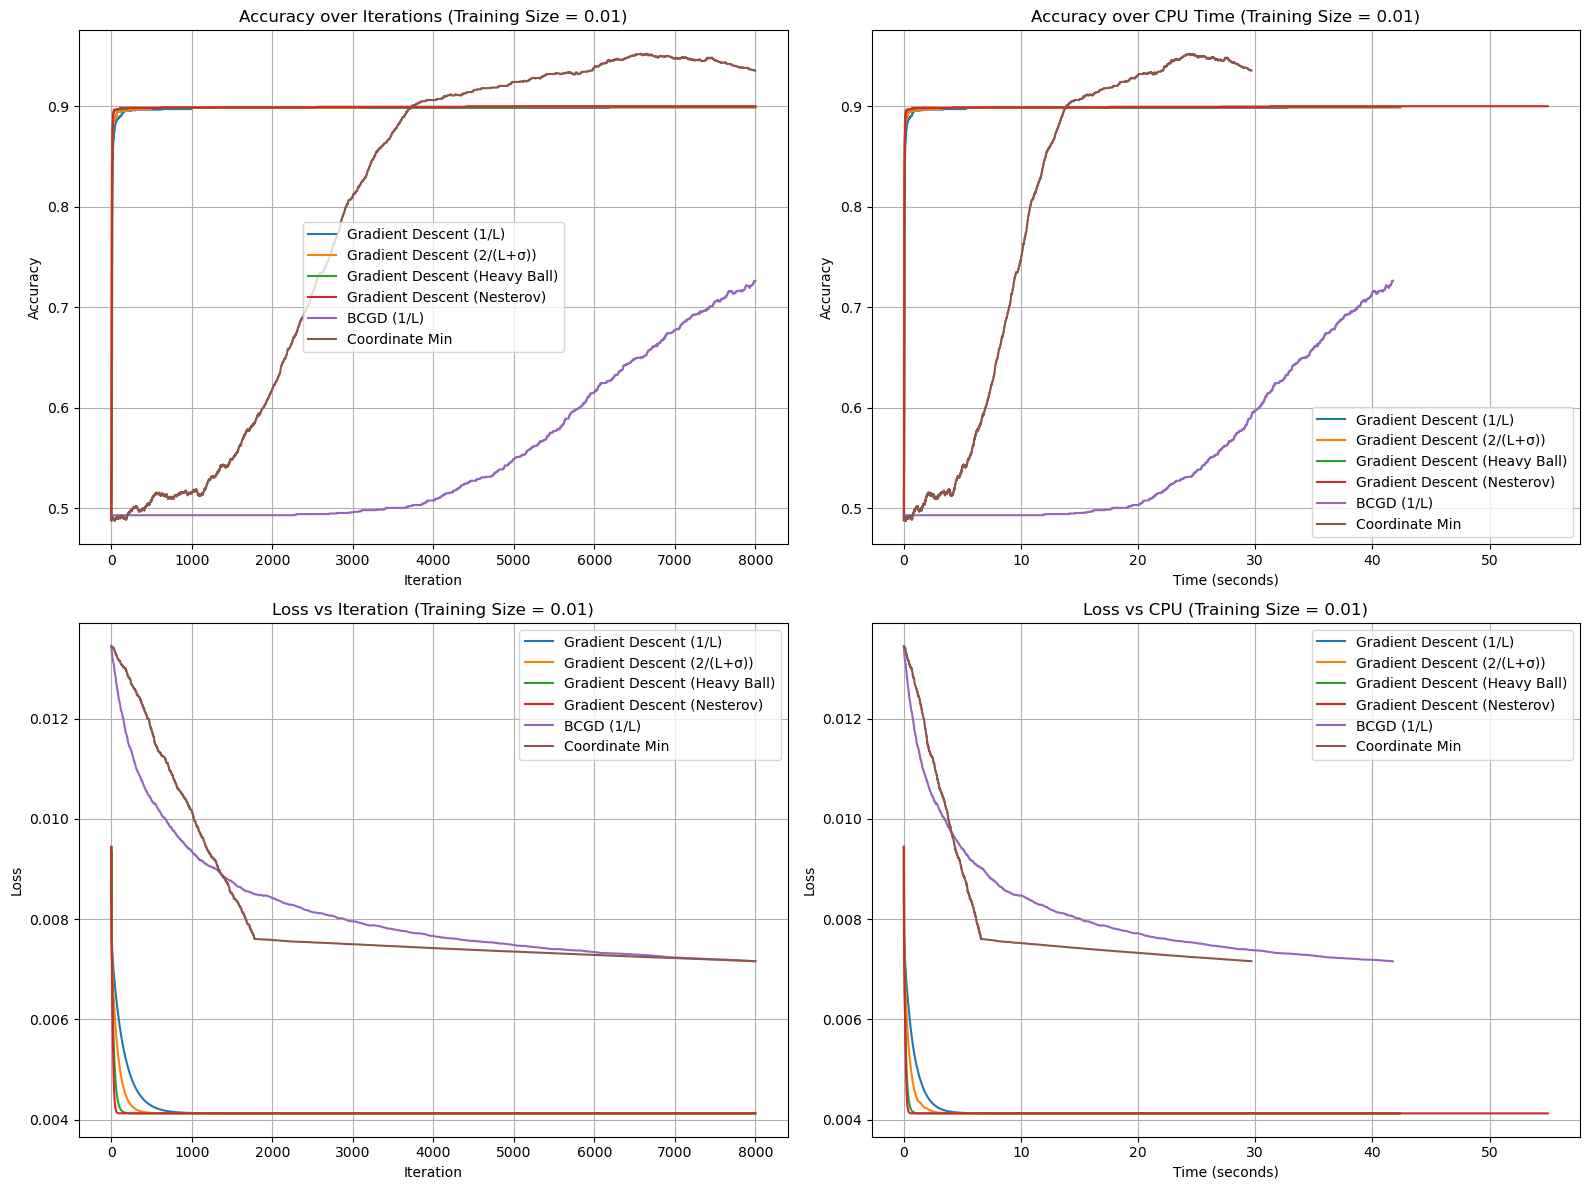

                          Solver  Accuracy  Precision    Recall        F1
0         Gradient Descent (1/L)  0.898876   0.000000  0.000000  0.000000
1     Gradient Descent (2/(L+σ))  0.898876   0.000000  0.000000  0.000000
2  Gradient Descent (Heavy Ball)  0.899438   0.000000  0.000000  0.000000
3    Gradient Descent (Nesterov)  0.900000   0.000000  0.000000  0.000000
4                     BCGD (1/L)  0.726404   0.104326  0.232955  0.144112
5                 Coordinate Min  0.935393   1.000000  0.346591  0.514768


In [25]:
# Load the digits dataset, reduced to 10 PCA components
# Also convert labels into a binary classification: 1 if digit == 0, else 0
X, y = load_digits_data_pca(n_components=10)

# Split the dataset into a small labeled subset and a large unlabeled subset
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(
    X, y, train_size=0.01, stratify=y, random_state=42)

# Print how many samples of class 0 and non-0 are in the labeled set
# Checking the imbalance
print("Labeled class distribution:", np.bincount(Y_labeled))

# Set random seeds for reproducibility of all randomized steps
np.random.seed(42)
random.seed(42)

# Initialize soft labels for the unlabeled set with values in [0, 1]
# These values will be optimized during training
y_init = np.random.rand(X_unlabeled.shape[0])

# Set RBF kernel parameter gamma
# common heurestic is to set gamma = 1 / num_features
gamma = 1 / X.shape[1]
max_iters = 8000

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")

# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "Gradient Descent (Heavy Ball)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.8),
    "Gradient Descent (Nesterov)": GradientDescentSolver(X_labeled,Y_labeled, X_unlabeled, y_init.copy(), lr = eta_1, momentum = 0.9, nesterov=True),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    #"BCGD (cache)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=True, lr=0.0005), 
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}

# Precompute the similarity matrices (using the RBF kernel)
for solver in solvers.values():
    solver.W_lu = rbf_kernel(solver.X_labeled, solver.X_unlabeled, gamma=gamma)
    solver.W_uu = rbf_kernel(solver.X_unlabeled, solver.X_unlabeled, gamma=gamma)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


for name, solver in solvers.items():
    acc_list = []  #stores accuracy at each iteration
    time_list = []    # stores elapsed CPU time at each iteration
    loss_list = []
    start_time = time.time()  # start timing the solver

    for _ in range(max_iters):

        # take one optimization step with the selected solver
        solver.step()
        
        # predict binary labels and assign 1, if soft-label > 0.5
        y_pred = (solver.y_unlabeled > 0.5)

        # compute accuracy on the unlabeled ground-truth labels
        acc = accuracy_score(Y_unlabeled, y_pred)
        acc_list.append(acc)

        

        # clip label values so they stay in the valid range [0, 1]
        np.clip(solver.y_unlabeled, 0, 1, out=solver.y_unlabeled)

        # Record elapsed CPU time
        elapsed = time.time() - start_time
        time_list.append(elapsed)

        # compute loss from the different solvers
        loss = solver.compute_loss()
        loss_list.append(loss)

    # Plot accuracy
    ax1.plot(acc_list, label=name)
    ax2.plot(time_list, acc_list, label=name)

    # Plot loss
    ax3.plot(loss_list, label=name)
    ax4.plot(time_list, loss_list, label=name)

ax1.set_title("Accuracy over Iterations (Training Size = 0.01)")
ax2.set_title("Accuracy over CPU Time (Training Size = 0.01)")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Time (seconds)")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
ax1.grid(); ax2.grid(); ax1.legend(); ax2.legend()

ax3.set_title('Loss vs Iteration (Training Size = 0.01)')
ax4.set_title('Loss vs CPU (Training Size = 0.01)')
ax3.set_xlabel('Iteration')
ax4.set_xlabel('Time (seconds)')
ax3.set_ylabel('Loss')
ax4.set_ylabel('Loss')
ax3.legend(); ax4.legend(); ax3.grid(); ax4.grid()
plt.tight_layout(); plt.show()

# Print final metrics
final_metrics = []
for name, solver in solvers.items():
    y_pred = (solver.y_unlabeled > 0.5).astype(int)
    final_metrics.append({
        'Solver': name,
        'Accuracy': accuracy_score(Y_unlabeled, y_pred),
        'Precision': precision_score(Y_unlabeled, y_pred, zero_division=0),
        'Recall': recall_score(Y_unlabeled, y_pred),
        'F1': f1_score(Y_unlabeled, y_pred)
    })

print(pd.DataFrame(final_metrics))


